In [1]:
%matplotlib inline
import qiskit
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)


IBMQ.load_account()
sim = Aer.get_backend('qasm_simulator')
provider = IBMQ.get_provider('ibm-q'); qcomp = provider.get_backend('ibmq_16_melbourne')
vector_sim = Aer.get_backend('statevector_simulator')

print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.14.1', 'qiskit-aer': '0.5.2', 'qiskit-ignis': '0.3.0', 'qiskit-ibmq-provider': '0.7.2', 'qiskit-aqua': '0.7.1', 'qiskit': '0.19.3'}


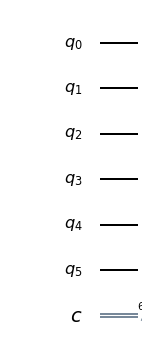

In [2]:
# We will make a 6 bit random number - so we need 6 qubits
len_digit = 6
qc = QuantumCircuit(len_digit, len_digit)
qc.draw('mpl')

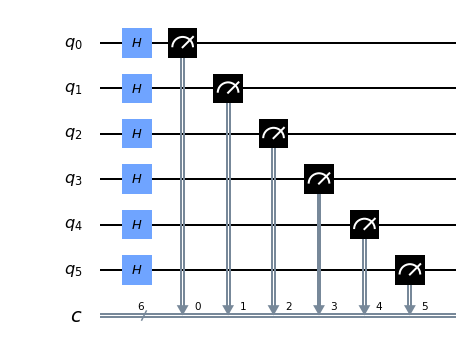

In [3]:
#We want every single possible combination of 0s and 1s to be equally likely. Hence, each qubit has to have a state such that it is equally likely to be measured as 0 or 1.
#For this we use a Hadamard Gate
for i in range(len_digit):
    qc.h(i)
    qc.measure(i, i)

qc.draw('mpl')

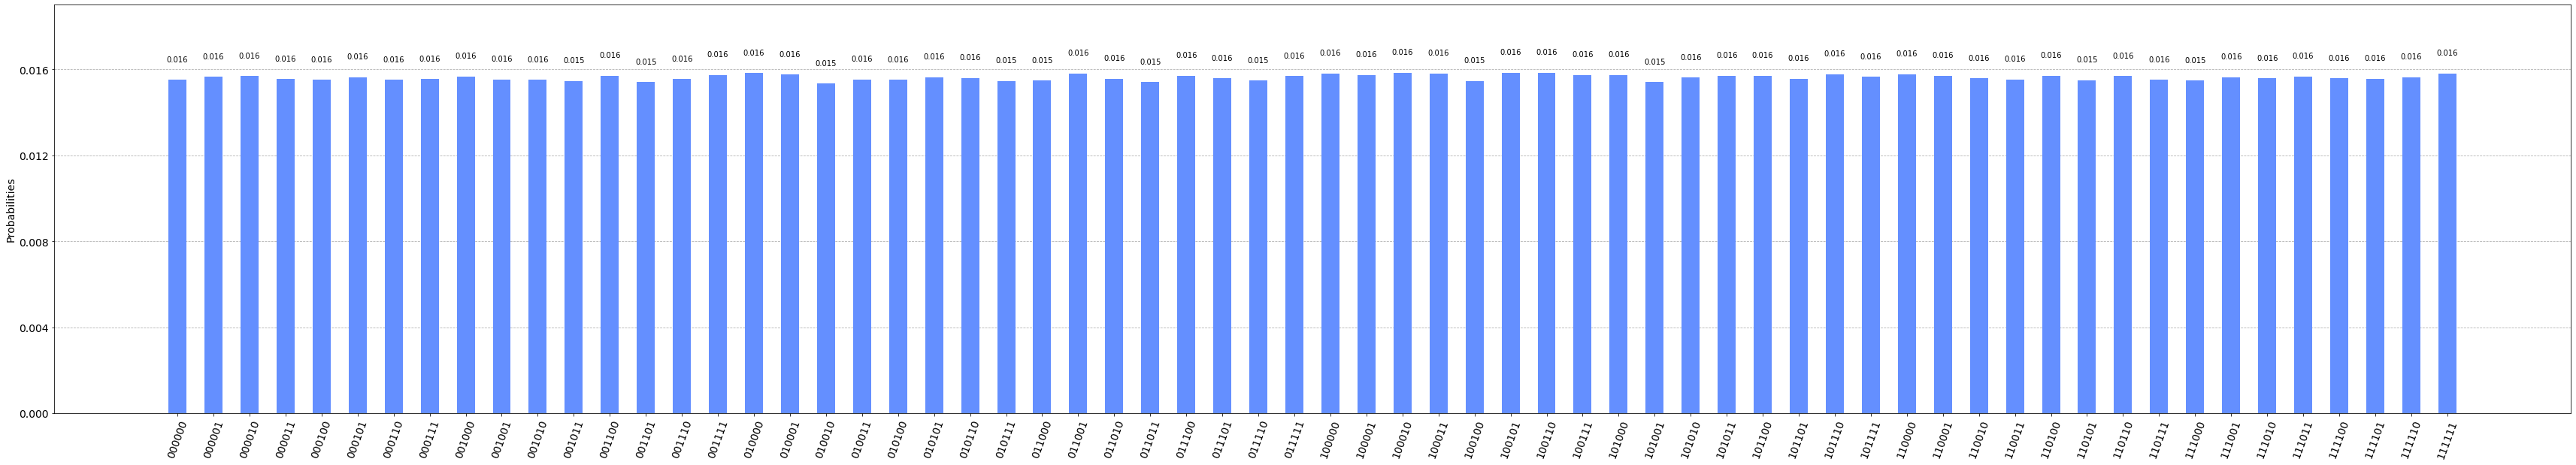

In [4]:
#And that's it! We now have a complete random number generator. Let's run it on the simulator and see the results. We will run it lots of times so that we get accurate results.
job = execute(qc, backend=sim, shots=1000000)
sim_result = job.result()
plot_histogram(sim_result.get_counts(), figsize=(60, 10))

Job Status: job has successfully run


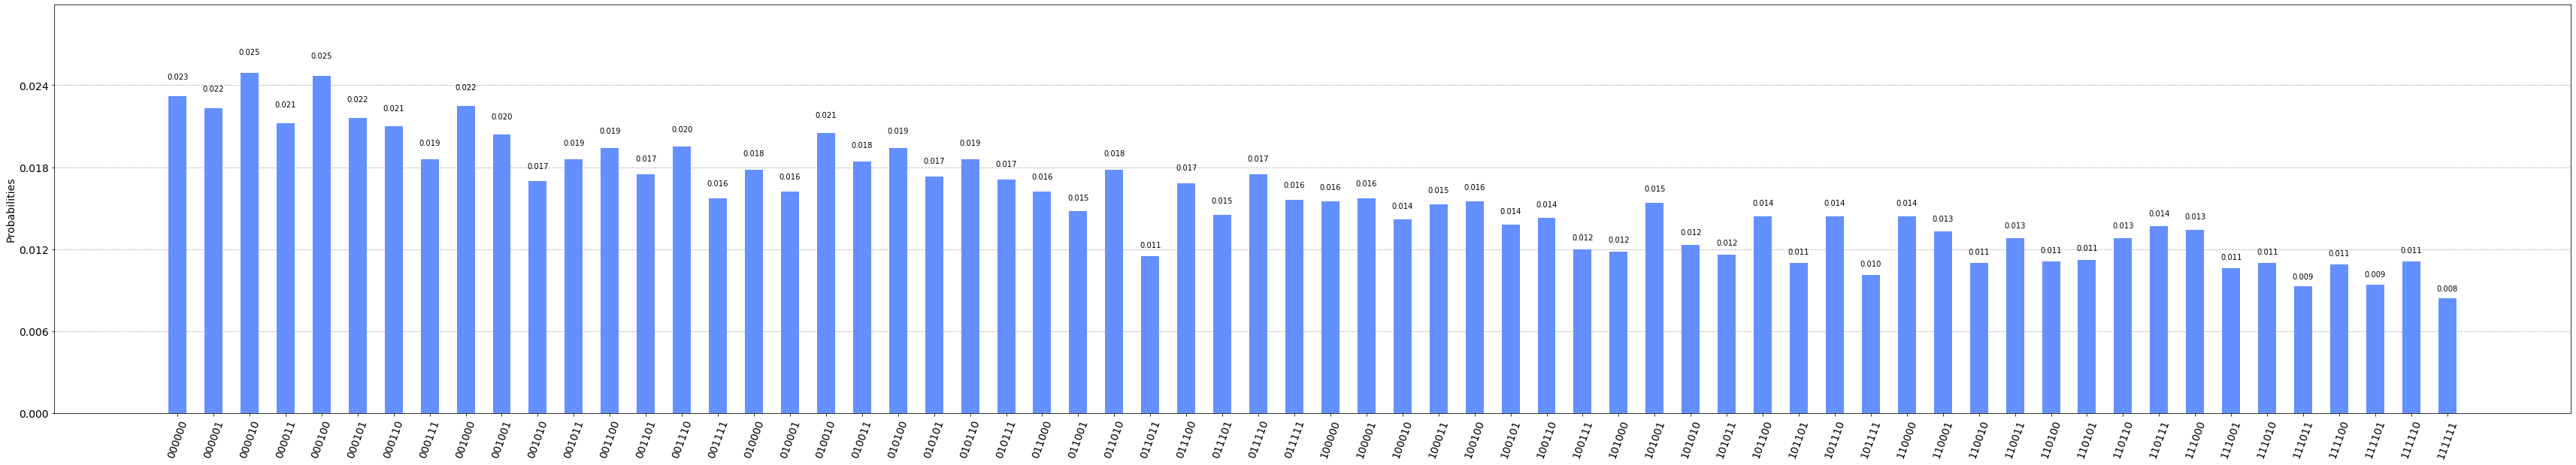

In [5]:
#Yes, all numbers are equally likely. Now let's run it on the quanutm computer
job = execute(qc, backend=qcomp, shots=8191)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(), figsize=(60, 10))

In [6]:
#It is not perfect. Part of the reason is that it is not running enough number of times, but partly because there is consistent noise as well. 
#Let's run Qiskit Noise Mitigation
cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel='measerrormitigationcal')
print(len(cal_circuits))
cal_job = execute(cal_circuits, backend=qcomp, shots=1024, optimization_level=0)
job_monitor(cal_job)

64
Job Status: job has successfully run


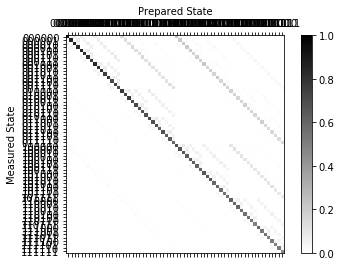

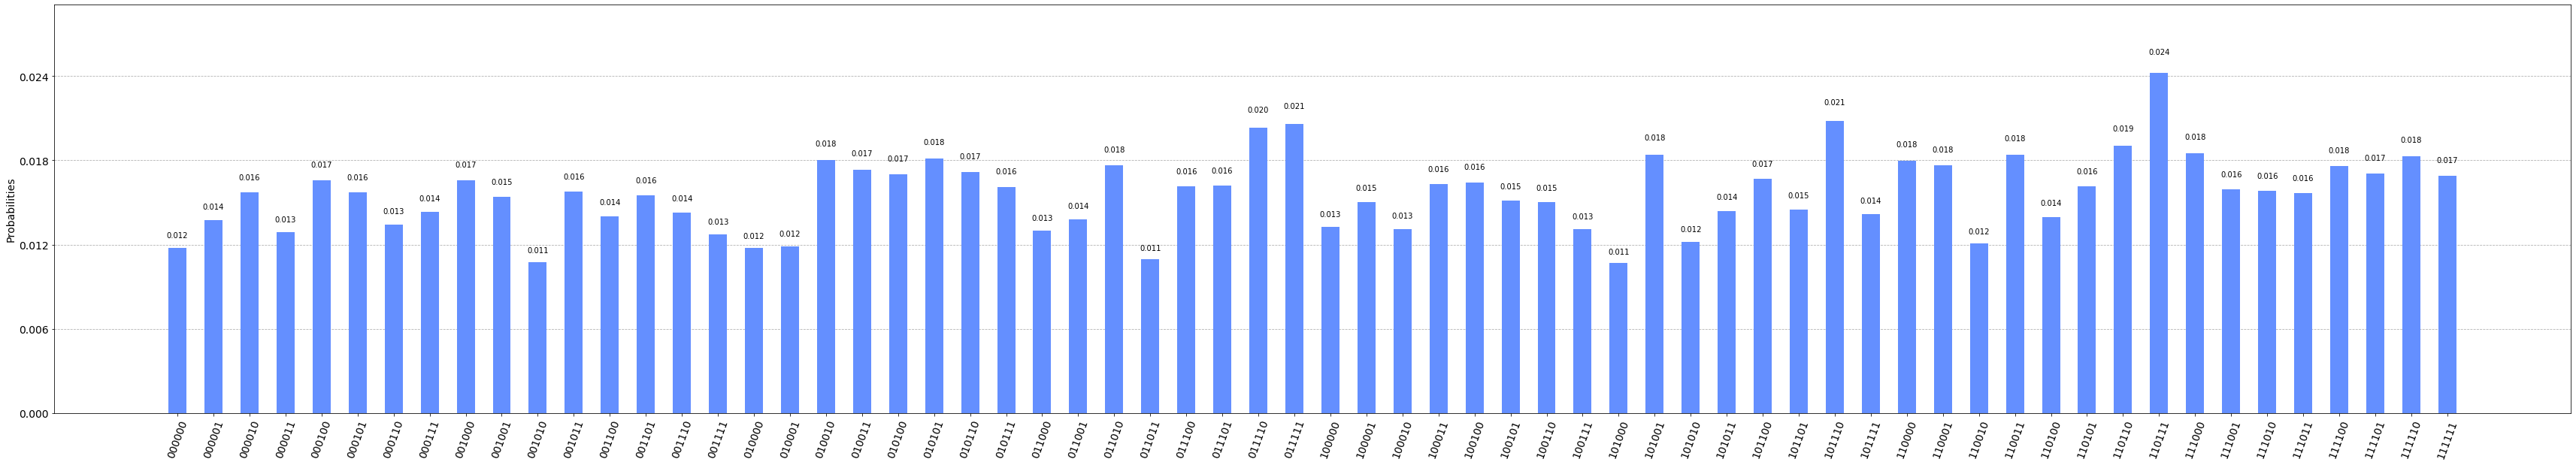

In [7]:
#Now we can apply the filter and see the results
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(result)
plot_histogram(mitigated_result.get_counts(), figsize=(60, 10))

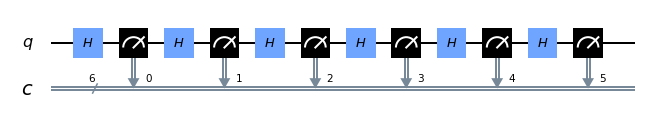

In [5]:
#We can see that it is much better. We finally have random numbers. Now the variability is mostly because of Few number of tries.
#However, if we want more detailed numbers, we will need more qubits using this approach, and for current quantum computers, 15 qubits is the max that can be accessed publicly.
#So let's make our program use only 1 qubit, but give us the same detail of numbers. This can then be extended to get a very deatiled number if you use both techniques in parallel.

qc = QuantumCircuit(1, len_digit)
for i in range(len_digit):
    qc.h(0)
    qc.measure(0, i)

qc.draw('mpl')

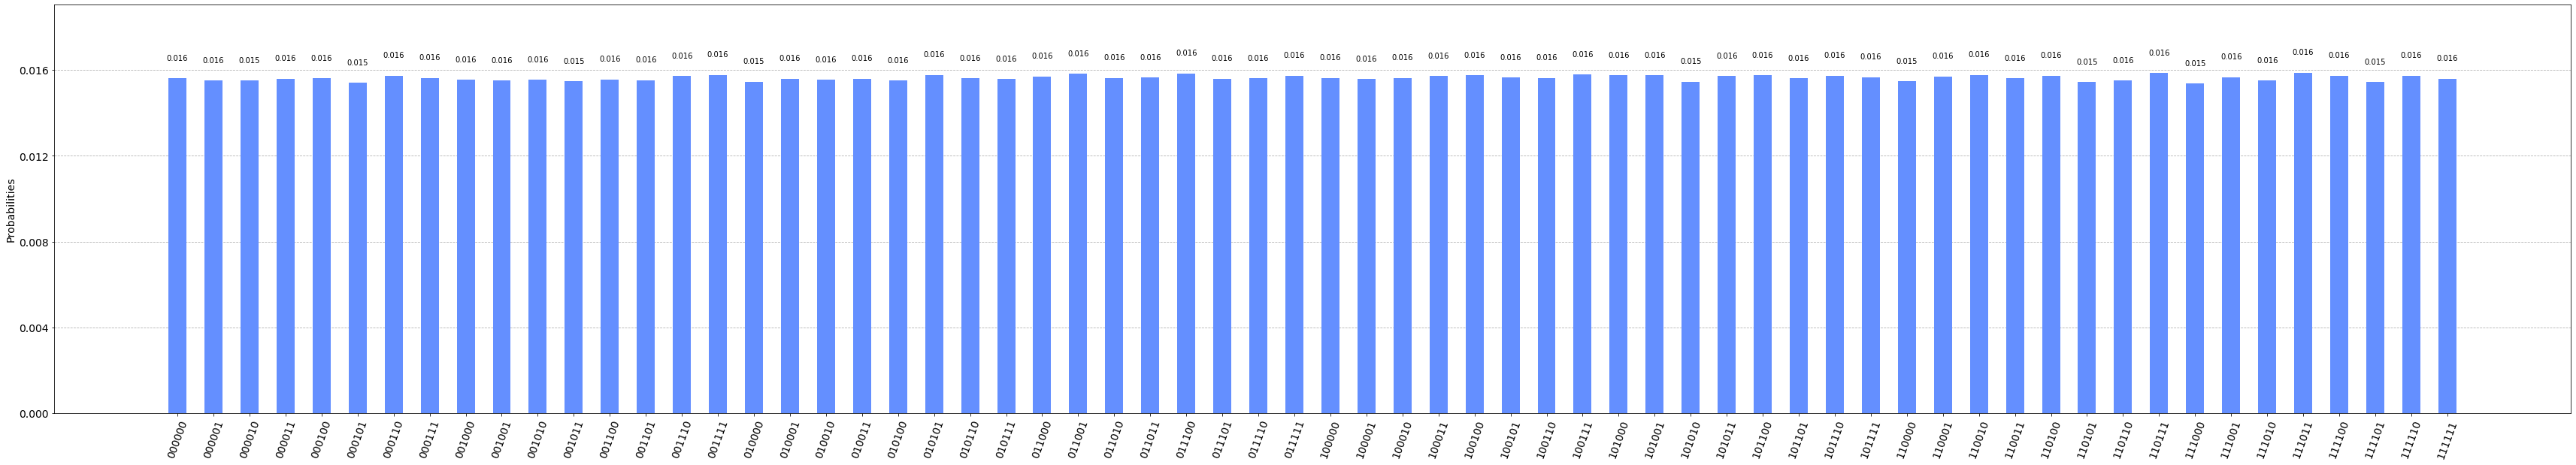

In [6]:
#When we run this circuit, we should get a 6 bit number, using only a single qubit. Note that we will still need the same number of classical bits.
job = execute(qc, backend=sim, shots=1000000)
sim_result = job.result()
plot_histogram(sim_result.get_counts(), figsize=(60, 10))

In [9]:
#Perfect random number generator using a single qubit! Works well on a simulator, but the problem is that real hardare doesn't support reusing qubits after a measurement.
#We can't run this on a real quantum computer now, because they don't support such an operation, but in the near future, it may be possible.